In [14]:
# Уберите комментарий и установите numba, если вы получаете сообщение "ModuleNotFoundError: No module named 'numba'".
# !pip3 install numba

In [1]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import timeit as tm
import psutil

# Задания.

#### 1. Изучите реализацию многомерных массивов numpy.ndarray и работу с ними в numba. Посмотрите ноутбук [FastPython.](../FastPython.ipynb) 

2. Реализуйте произведение матриц $A\in Mat(N\times K)$, $B\in Mat(K\times M)$ согласно определению
$$
C_{n,m}=\sum_{k=1}^K A_{n,k}B_{k,m}.
$$
Сравните быстродействие реализаций на основе numpy.sum, с помощью numba и стандартный метод numpy.dot.
Насколько полно используется процессор? 
Сколько используется памяти?

3. Составьте модель использования вычислительных ресурсов функцией на основе numba.jit из предыдущего пункта.
Размеры матриц должны быть параметрами модели.
Проведите вычислительные эксперименты, чтобы подобрать параметры модели.
Экстраполируйте результат на большие матрицы, сделайте экспериментальную проверку.

4. В простейшем алгоритме произведения матриц используются три цикла: перебирающие элементы $n$ и $m$  матрицы $C$
и суммирующие по $k$. 
Сравните время перемножения матриц в зависимости от порядка циклов.
Оцените объем кэшей разных уровней, проводя эксперименты для матриц разного размера.

5. Обновите функцию для перемножения матриц, используя несколько потоков с помощью numba.prange.
Обновите модель использования вычислительных ресурсов, принимая во внимание число потоков.
Оцените параметры модели из эксперимента.
Какое [параллельное ускорение](https://en.wikipedia.org/wiki/Amdahl%27s_law) вы получили?

6. Сможете ли вы реализовать реализовать на С более быстрый вариант перемножения матриц, чем на numba?

7. Реализуйте быстрое произведение матриц, например, используйте [алгоритм Штрассена](https://en.wikipedia.org/wiki/Strassen_algorithm).
Оцените, на матрицах какого размера быстрое произведение матриц быстрее, чем стандартная реализация.
Какой из методов дает меньшую погрешность вычислений?


In [2]:
def default_multiply(a,b):
    c = np.zeros((a.shape[0],b.shape[1]))
    for i in range(a.shape[1]):
        for j in range(a.shape[0]):
            for l in range(b.shape[1]):
                c[j][l] += a[j][i]*b[i][l]
    return c

def test1(c,c_numpy):
    if (c==c_numpy).all()!=1:
        return 0
    else:
        return 1
    
@nb.njit('float64[:,:](float64[:,:],float64[:,:])',parallel=True)
def numba_multiply(a,b):
    c = np.zeros((a.shape[0],b.shape[1]))
    for i in nb.prange(a.shape[1]):
        for j in nb.prange(a.shape[0]):
            for l in nb.prange(b.shape[1]):
                c[j][l] += a[j][i]*b[i][l]
    return c

In [3]:
number_space = np.linspace(100,1000,10)

def matrix(x,y):
    out = np.random.rand(x, y)
    return out

In [4]:
def default_time():
    def_time = [[0 for j in range(len(number_space))] for i in range(2)]
    def_hard = [0 for j in range(len(number_space))]
    i=0
    for n in number_space:
        def_time[0][i] = tm.timeit(stmt="default_multiply(Am[:,:],Bm[:,:])",number=10,
                                    globals= {'default_multiply':default_multiply, 'Am': matrix(100,int(n)), 'Bm' : matrix(int(n),100)})
        #print(d3ef_time[0][i])
        def_time[1][i]=n
        def_hard[i]=psutil.cpu_percent(def_time[0][i])
        i+=1
    return def_time, def_hard
def_time, def_hard = default_time()

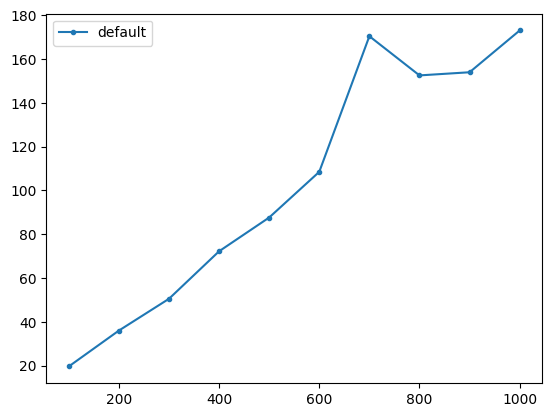

In [5]:
plt.plot(def_time[1],def_time[0], label="default", marker='.')
plt.legend()
plt.show()

In [6]:
def nb_time(thrds):
    numba_time = [[0 for j in range(len(number_space))] for i in range(2)]
    numba_hard = [0 for j in range(len(number_space))]
    i=0
    for n in number_space:
        #print(n)
        numba_time[0][i]=tm.timeit(stmt="numba_multiply(Am[:,:],Bm[:,:])",number=10,
                                    globals= {'numba_multiply':numba_multiply, 'Am': matrix(100,int(n)), 'Bm' : matrix(int(n),100), "nb.set_num_threads": nb.set_num_threads},
                                    setup = """
from numba import set_num_threads
set_num_threads(%s)"""
%thrds)
        numba_time[1][i]=n
        numba_hard[i]=psutil.cpu_percent(numba_time[0][i])
        i+=1
    return numba_time, numba_hard

nb_time_1, numba_hard_1 = nb_time(1)
nb_time_2, numba_hard_2 = nb_time(2)
nb_time_4, numba_hard_4 = nb_time(4)
nb_time_8, numba_hard_8 = nb_time(8)

In [7]:
def numpy_multy(a,b):
    c=np.dot(a,b)
    return c

def numpy_time():
    np_time = [[0 for j in range(len(number_space))] for i in range(2)]
    np_hard = [0 for j in range(len(number_space))]
    i=0
    for n in number_space:
        np_time[0][i] = tm.timeit(stmt="numpy_multy(Am[:,:],Bm[:,:])",number=10,
                                    globals= {'numpy_multy' : numpy_multy, 'Am': matrix(100,int(n)), 'Bm' : matrix(int(n),100)})
        #print(np_time[0][i])
        np_time[1][i]=n
        np_hard[i]=psutil.cpu_percent(np_time[0][i])
        i+=1
    return np_time, np_hard
np_time, np_hard = numpy_time()
#print(np_time)

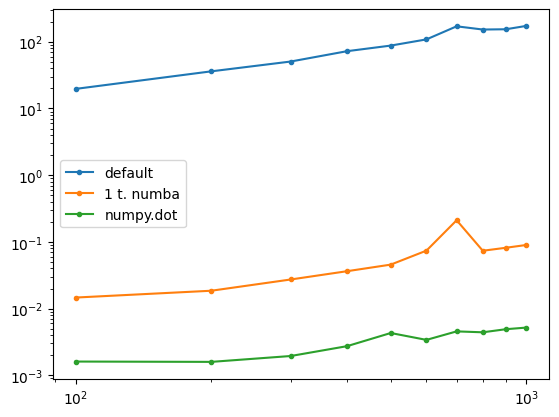

In [8]:
plt.plot(def_time[1],def_time[0], label="default", marker='.')
plt.plot(nb_time_1[1],nb_time_1[0],label = "1 t. numba", marker='.')
plt.plot(np_time[1],np_time[0],label = "numpy.dot", marker='.')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

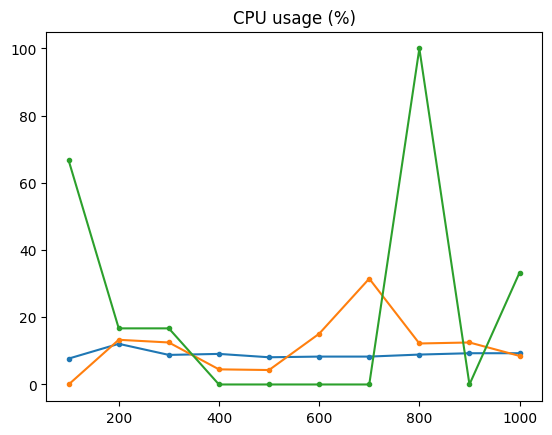

In [9]:
plt.plot(def_time[1],def_hard, label="default", marker='.')
plt.plot(nb_time_1[1],numba_hard_1,label = "1 t. numba", marker='.')
plt.plot(np_time[1],np_hard,label = "numpy.dot", marker='.')
plt.title("CPU usage (%)")
plt.show()

#### Модель

Есть 3 координаты модели, которые меняются для двух матриц a, b: N (a.shape[0]), M (a.shape[1]=b.shape[0]), K (b.shape[1])\
В ходе вычислений вариьируется координата M матриц.
Рассмотрю функции от всех возможных комбинаций координат для модели кода умножения матриц:

def default_multiply(a,b):\
    c = np.zeros((a.shape[0],b.shape[1]))\
    for i in range(a.shape[1]):\
        for j in range(a.shape[0]):\
            for l in range(b.shape[1]):\
                c[j][l] += a[j][i]*b[i][l]\
    return c
    
$F_t(N,M,K) = \alpha_1\cdot(NMK)+\alpha_2\cdot(NK)+\alpha_3$, $\,\,\,\,\,\,\,$ [F_t] = сек

$\alpha_1$ отвечает времени, тратящегося на запись в матрицу с результат вычисления\
$\alpha_2$ -//-//- на запись в память матрицы с\
$\alpha_3$ -//-//- на вычисление функций, не зависящих от размера матриц (считаем что .shape() не зависит)

In [ ]:
def model_lin(a,b):
    N = a.shape[0]
    M = b.shape[0]
    K = b.shape[1]
    return 0

In [1]:
def model_double(a,b):
    c = np.zeros((a.shape[0],b.shape[1]))
    return 0

In [ ]:
def model_triple():

In [ ]:
def function(N,M,K):
    return alpha1*N*M*K + alpha2*N*K + alpha3

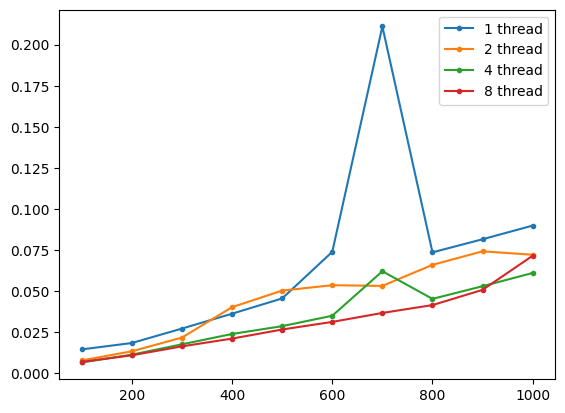

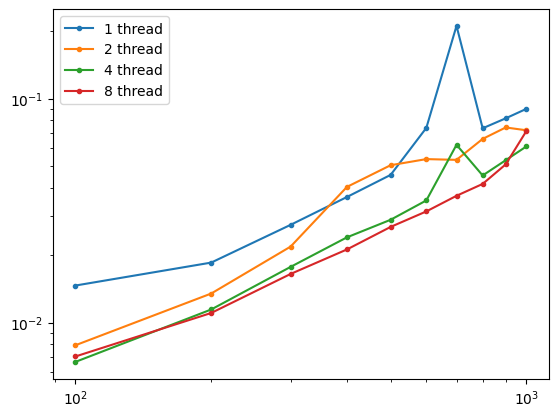

In [10]:
plt.plot(nb_time_1[1],nb_time_1[0],label = "1 thread", marker='.')
plt.plot(nb_time_2[1],nb_time_2[0],label = "2 thread", marker='.')
plt.plot(nb_time_4[1],nb_time_4[0],label = "4 thread", marker='.')
plt.plot(nb_time_8[1],nb_time_8[0],label = "8 thread", marker='.')
plt.legend()
plt.show()

plt.plot(nb_time_1[1],nb_time_1[0],label = "1 thread", marker='.')
plt.plot(nb_time_2[1],nb_time_2[0],label = "2 thread", marker='.')
plt.plot(nb_time_4[1],nb_time_4[0],label = "4 thread", marker='.')
plt.plot(nb_time_8[1],nb_time_8[0],label = "8 thread", marker='.')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

#%timeit c_def = default_multiply(a,b)
#%timeit c_numpy = np.dot(a,b)
#%timeit c_numba = numba_multiply(a,b)

#c_def = default_multiply(a,b)
#c_numpy = np.dot(a,b)
#c_numba = numba_multiply(a,b)

#if test1(c_def,c_numpy) == False:
#    print("Ошибка в вычислении def")
#
#if test1(c_numba,c_numpy) == False:
#    print("Ошибка в вычислении nb")

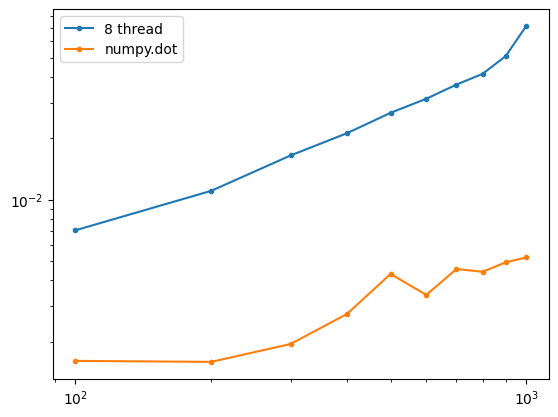

In [11]:
plt.plot(nb_time_8[1],nb_time_8[0],label = "8 thread", marker='.')
plt.plot(np_time[1],np_time[0],label = "numpy.dot", marker='.')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

In [12]:
def def_row_col(a,b):
    """
    rows->columns
    """
    rc = np.zeros((a.shape[0],b.shape[1]))
    for i in range(a.shape[1]):
        for j in range(a.shape[0]):
            for l in range(b.shape[1]):
                rc[j][l] += a[j][i]*b[i][l]
    return rc
def def_col_row(a,b):    
    """
    columns->rows
    """
    cr = np.zeros((a.shape[0],b.shape[1]))
    for j in range(a.shape[0]):
        for i in range(a.shape[1]):
            for l in range(b.shape[1]):
                cr[j][l] += a[j][i]*b[i][l]
    return cr

In [13]:
number_space_def = np.logspace(1,2,num=5)
print(number_space_def)

[ 10.          17.7827941   31.6227766   56.23413252 100.        ]


In [14]:
def compare_def_time():
    comp_time_rc = [[0 for j in range(len(number_space))] for i in range(2)]
    comp_time_cr = [[0 for j in range(len(number_space))] for i in range(2)]
    M = np.random.randint(10,1000)
    K = np.random.randint(10,1000)
    i=0
    for n in number_space_def:
        A_compare = matrix(M,int(n))
        B_compare = matrix(int(n),K)
        comp_time_rc[0][i] = tm.timeit(stmt="def_row_col(A_compare[:,:],B_compare[:,:])",number=1,
                                    globals= {'def_row_col' : def_row_col, 'A_compare': A_compare, 'B_compare' : B_compare})
        comp_time_cr[0][i] = tm.timeit(stmt="def_col_row(A_compare[:,:],B_compare[:,:])",number=1,
                                    globals= {'def_col_row' : def_col_row, 'A_compare': A_compare, 'B_compare' : B_compare})
        print(comp_time_rc[0][i])
        print(comp_time_cr[0][i])
        comp_time_rc[1][i] = n
        comp_time_cr[1][i] = n
        i+=1
    return comp_time_rc, comp_time_cr

comp_time_rc,comp_time_cr = compare_def_time()

0.3360225999999784
0.34379500000022745
0.540509800000109
0.5685838999997941
0.9978898999997909
1.011737499999981
1.706744499999786
1.6911189999996168
3.0737145000002783
3.154182100000071


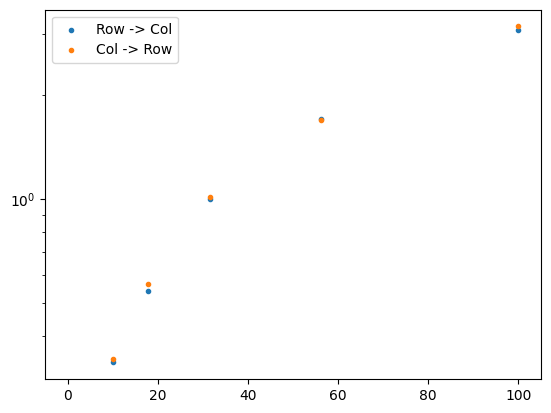

In [15]:
plt.scatter(comp_time_rc[1],comp_time_rc[0],label = "Row -> Col", marker='.')
plt.scatter(comp_time_cr[1],comp_time_cr[0],label = "Col -> Row", marker='.')
plt.yscale('log')
plt.legend()
plt.show()

### Штрассен. Реализация

In [16]:
def blocks(m):
    len_mas = m.shape[0]//2
    lu = m[:len_mas, :len_mas]
    ru = m[:len_mas, len_mas:]
    ld = m[len_mas:, :len_mas]
    rd = m[len_mas:, len_mas:]

    return lu, ru, ld, rd

In [17]:
def strassen_multy(a,b):
    if a.shape[0] <= 4 and a.shape[1] <= 4 and b.shape[0] <= 4 and b.shape[1] <= 4:
        return numba_multiply(a,b)
    
    a11, a12, a21, a22 = blocks(a)
    b11, b12, b21, b22 = blocks(b)
    
    d1 = strassen_multy(a11+a22, b11+b22)
    d2 = strassen_multy(a21+a22, b11)
    d3 = strassen_multy(a11, b12-b22)
    d4 = strassen_multy(a22, b21-b11)
    d5 = strassen_multy(a11+a12, b22)
    d6 = strassen_multy(a21-a11, b11+b12)
    d7 = strassen_multy(a12-a22, b21+b22)

    c11 = d1+d4+d7-d5
    c12 = d3+d5
    c21 = d2+d4
    c22 = d1+d3+d6-d2
    
    #print(c11)
    #print(c12)
    #print(c21)
    #print(c22)
    
    '''
    c_out0=[]
    c_out1=[]
    
    for i in range(a.shape[0]//2):
        print(c_out0)
        print(c_out1)
        c_out0.append(np.ravel([c11[i],c12[i]]))
        c_out1.append(np.ravel([c21[i],c22[i]]))
    '''
    c_out0 = np.array([np.ravel([c11[i], c12[i]]) for i in range(a.shape[0]//2)])
    c_out1 = np.array([np.ravel([c21[i], c22[i]]) for i in range(a.shape[0]//2)])
    c_out = np.concatenate((c_out0,c_out1))
    
    return c_out

In [18]:
number_space_str = np.logspace(1,15,base=2,num=15)
print(number_space_str)

[2.0000e+00 4.0000e+00 8.0000e+00 1.6000e+01 3.2000e+01 6.4000e+01
 1.2800e+02 2.5600e+02 5.1200e+02 1.0240e+03 2.0480e+03 4.0960e+03
 8.1920e+03 1.6384e+04 3.2768e+04]


In [19]:
number_space_str = np.linspace(1,15,10)

In [28]:
def strass_time():
    str_time = [[0 for j in range(len(number_space_str))] for i in range(2)]
    i=0
    for n in number_space_str:
        Am = matrix(2**int(n),2**int(n))
        Bm = matrix(2**int(n),2**int(n))
        str_time [0][i] = tm.timeit(stmt="strassen_multy(Am[:,:],Bm[:,:])",number=10,
                                    globals= {'strassen_multy' : strassen_multy, 'Am': Am, 'Bm' : Bm})
        str_time [1][i]=n
        i+=1
        print("str "+str(n))
    return str_time

def nb_time_mod():
    numba_time = [[0 for j in range(len(number_space_str))] for i in range(2)]
    i=0
    for n in number_space_str:
        Am = matrix(2**int(n),2**int(n))
        Bm = matrix(2**int(n),2**int(n))
        numba_time[0][i]=tm.timeit(stmt="numba_multiply(Am[:,:],Bm[:,:])",number=10,
                                    globals= {'numba_multiply':numba_multiply, 'Am': Am, 'Bm' : Bm, "nb.set_num_threads": nb.set_num_threads},
                                    setup = """
from numba import set_num_threads
set_num_threads(%s)"""
%8)
        numba_time[1][i]=n
        i+=1
        print("nb"+str(n))
    return numba_time

In [ ]:
strass_time_out = strass_time() 

plt.scatter(strass_time_out[1],strass_time_out[0],label = "Strassen", marker='.')
plt.scatter(nb_time_mod[1],nb_time_mod[0],label = "Numba. 8th.", marker='.')
plt.yscale('log')
plt.legend()
plt.show()

str 1.0
str 2.5555555555555554
str 4.111111111111111
str 5.666666666666667
str 7.222222222222222
str 8.777777777777779


# Дополнительные задания

1. Реализуйте вычисление матрицы дискретизованного конечными разностями оператора Лапласа:
$$
Lf_{n,k}=4f_{n,k}-f_{n+1,k}-f_{n-1,k}-f_{n,k+1}-f_{n,k-1}.
$$

Функция $f$ задана на квадратной решетке своими значениями в узлах $f_{n,k}$, $n=0\ldots N$, $k=0\ldots K$.
Мы будем предполагать периодические граничные условия, в этом случае арифметические операции над индексом $n$ выполняются по модулю $N$, а по индексу $k$ по модулю $K$.
Хотя значения функции и хранятся в двухмерном массиве, с точки зрения матричных вычислений значения функции $f$ в узлах образуют вектор, а оператор $L$ действует на него умножением на матрицу.
Если нас смущает двойной индекс $(n,k)$ у $f$, то мы можем держать в голове, что это просто удобное обозначение для одного числа $n*K+k$, показывающего, в какой ячейке памяти хранится коэффициент вектора.
Оператор $L$ может быть задан своей матрицей:
$$
Lf_{n,k}=\sum_{n',k'}L_{n,k,n',k'} f_{n',k'},
$$
где $(n,k)$ - номер строки матрицы, а $(n',k')$ - номер столбца. 
Двойные индексы можно свернуть снова в обычные числа, тогда матрица будем иметь два индекса (строки и столбец), как нам более привычно. 
Однако, использование двойных индексов позволяет нам записать матрицу в очень простом виде:
$$
L_{n,k,n',k'}=
\begin{cases}
4, & n=n'\text{ и }k=k',\\
-1, & n=n'\pm 1\text{ и }k=k'\text{ или }n=n'\text{ и }k=k'\pm1,\\
0, & \text{в остальных случаях}. 
\end{cases}
$$

2. Матрица $L$ [разреженная](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D0%B7%D1%80%D0%B5%D0%B6%D0%B5%D0%BD%D0%BD%D0%B0%D1%8F_%D0%BC%D0%B0%D1%82%D1%80%D0%B8%D1%86%D0%B0), т.е. большинство ее элементов равно нулю. 
Сохраните матрицу $L$ в виде разреженной матрицы из пакета [scipy.sparse](https://docs.scipy.org/doc/scipy/reference/sparse.html).
Какой способ хранения разреженной матрицы подходит лучше всего для матрицы оператора Лапласа?
Какими преимуществами обладает представление матрицы в разреженном виде?

3. Выше приведена формула для вычисления матрицы $L$ на векторах $f$, которая может быть реализована в виде алгоритма более быстрого, чем умножение на произвольню матрицу. Реализуйте функцию, которая будет вычислять произведение $L$ на $f$ без явного использования матрицы $L$. Воспользуйтесь [numpy](https://numpy.org/), постарайтесь реализовать как можно более быстрый код. Сравните полученное быстродействие с максимальной производительностью процессора вашего компьютера, согласно спецификации. 

4. Перепишите функцию из предыдущего задания, используя [numba](https://numba.pydata.org/). Какое ускорение мы можем ожидать, за счет чего оно достигается? Реализуйте наиболее эффективный код, учитывая аппаратные особенности компьютера. Убедитесь, что производительность вашего кода выше, чем умножение на разреженную матрицу, полученную выше. Как близко вы подобрались к пиковой теоретической производительности вашего компьютера?

# Литература

1. Ван Лоун Чарльз Ф., Голуб Джин Х. Матричные вычисления. Глава 1.

1. [NumPy](https://numpy.org/doc/stable/contents.html)

1. [Numba: A High Performance Python Compiler.](https://numba.pydata.org/) [Performance Tips](https://numba.pydata.org/numba-doc/latest/user/performance-tips.html)

1. [JAX: Autograd and XLA](https://github.com/google/jax)

1. [xeus-cling: a Jupyter kernel for C++](https://github.com/jupyter-xeus/xeus-cling)

1. [Minimal C kernel for Jupyter](https://github.com/brendan-rius/jupyter-c-kernel)

1. Micha Gorelick, Ian Ozsvald.
[High Performance Python](https://www.oreilly.com/library/view/high-performance-python/9781449361747/) 

1. [Performance Tips of NumPy ndarray](https://shihchinw.github.io/2019/03/performance-tips-of-numpy-ndarray.html)

1. [Beating NumPy performance speed by extending Python with C](https://medium.com/analytics-vidhya/beating-numpy-performance-by-extending-python-with-c-c9b644ee2ca8)

1. [Principles of Performance](https://llllllllll.github.io/principles-of-performance/index.html)